In [1]:
import pandas as pd 
import numpy as np 

from sklearn.dummy import  DummyClassifier
from sklearn.model_selection import train_test_split, cross_val_score 
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression 
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC 
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.tree import DecisionTreeClassifier

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_recall_curve

from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN 
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN 
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy.stats import pearsonr

from sklearn.pipeline import Pipeline 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder 
import joblib
import warnings

In [2]:
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [3]:
df = pd.read_csv("Dataset.csv")

df.head(3)

,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NAME,EQUIP_CD,EQUIP_NAME,PassOrFail,Reason,Injection_Time,...,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
0,5f8928bb9c0189cc666ef19b,2020-10-16 04:57:47,2020-10-16 오전 12:00:00,24,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,NaN,9.59,...,24.799999,27.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,5f8928de9c0189cc666ef20b,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,24,CN7 W/S SIDE MLD'G RH,S14,650톤-우진2호기,Y,NaN,9.60,...,24.799999,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,5f8928df9c0189cc666ef213,2020-10-16 04:58:48,2020-10-16 오전 12:00:00,23,CN7 W/S SIDE MLD'G LH,S14,650톤-우진2호기,Y,NaN,9.60,...,24.799999,27.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
df['PART_NAME'].value_counts()

PART_NAME
CN7 W/S SIDE MLD'G RH        3371
CN7 W/S SIDE MLD'G LH        3365
RG3 MOLD'G W/SHLD, LH         628
RG3 MOLD'G W/SHLD, RH         628
SP2 CVR ROOF RACK CTR, RH       2
JX1 W/S SIDE MLD'G RH           2
Name: count, dtype: int64

In [6]:
# Filter needed category 
target_part = ["RG3 MOLD'G W/SHLD, RH", "RG3 MOLD'G W/SHLD, LH"] 
df_filtered = df[df['PART_NAME'].isin(target_part)].copy()
df_filtered.head(3)

,_id,TimeStamp,PART_FACT_PLAN_DATE,PART_FACT_SERIAL,PART_NAME,EQUIP_CD,EQUIP_NAME,PassOrFail,Reason,Injection_Time,...,Mold_Temperature_3,Mold_Temperature_4,Mold_Temperature_5,Mold_Temperature_6,Mold_Temperature_7,Mold_Temperature_8,Mold_Temperature_9,Mold_Temperature_10,Mold_Temperature_11,Mold_Temperature_12
1211,5f8f87c09c0189cc6679187a,2020-10-21 00:57:37,2020-10-21 오전 12:00:00,17,"RG3 MOLD'G W/SHLD, LH",S14,650톤-우진2호기,Y,NaN,1.06,...,21.6,22.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1212,5f8f87c09c0189cc6679187d,2020-10-21 00:57:37,2020-10-21 오전 12:00:00,18,"RG3 MOLD'G W/SHLD, RH",S14,650톤-우진2호기,Y,NaN,1.06,...,21.6,22.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1213,5f8f87c09c0189cc66791885,2020-10-21 00:56:34,2020-10-21 오전 12:00:00,17,"RG3 MOLD'G W/SHLD, LH",S14,650톤-우진2호기,Y,NaN,1.06,...,21.5,22.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
# Convert to include variable in numeric format
print("\nУникальные значения в целевой переменной до преобразования:")
print(df_filtered['PassOrFail'].unique())


Уникальные значения в целевой переменной до преобразования:
[1 0]


In [57]:
# Creating a dictionary for conversion
pass_fail_mapping = {'Y': 1, 'N': 0, 'Yes': 1, 'No': 0, '1': 1, '0': 0}
df_filtered['PassOrFail'] = df_filtered['PassOrFail'].map(pass_fail_mapping)

In [58]:
# Checking the conversion result
print("\nУникальные значения в целевой переменной после преобразования:")
print(df_filtered['PassOrFail'].unique())


Уникальные значения в целевой переменной после преобразования:
[nan]


In [10]:
# Data Type Analysis
print("\nТипы данных в датасете:")
print(df_filtered.dtypes)


Типы данных в датасете:
_id                          object
TimeStamp                    object
PART_FACT_PLAN_DATE          object
PART_FACT_SERIAL              int64
PART_NAME                    object
EQUIP_CD                     object
EQUIP_NAME                   object
PassOrFail                    int64
Reason                       object
Injection_Time              float64
Filling_Time                float64
Plasticizing_Time           float64
Cycle_Time                  float64
Clamp_Close_Time            float64
Cushion_Position            float64
Switch_Over_Position        float64
Plasticizing_Position       float64
Clamp_Open_Position         float64
Max_Injection_Speed         float64
Max_Screw_RPM               float64
Average_Screw_RPM           float64
Max_Injection_Pressure      float64
Max_Switch_Over_Pressure    float64
Max_Back_Pressure           float64
Average_Back_Pressure       float64
Barrel_Temperature_1        float64
Barrel_Temperature_2        float64
Bar

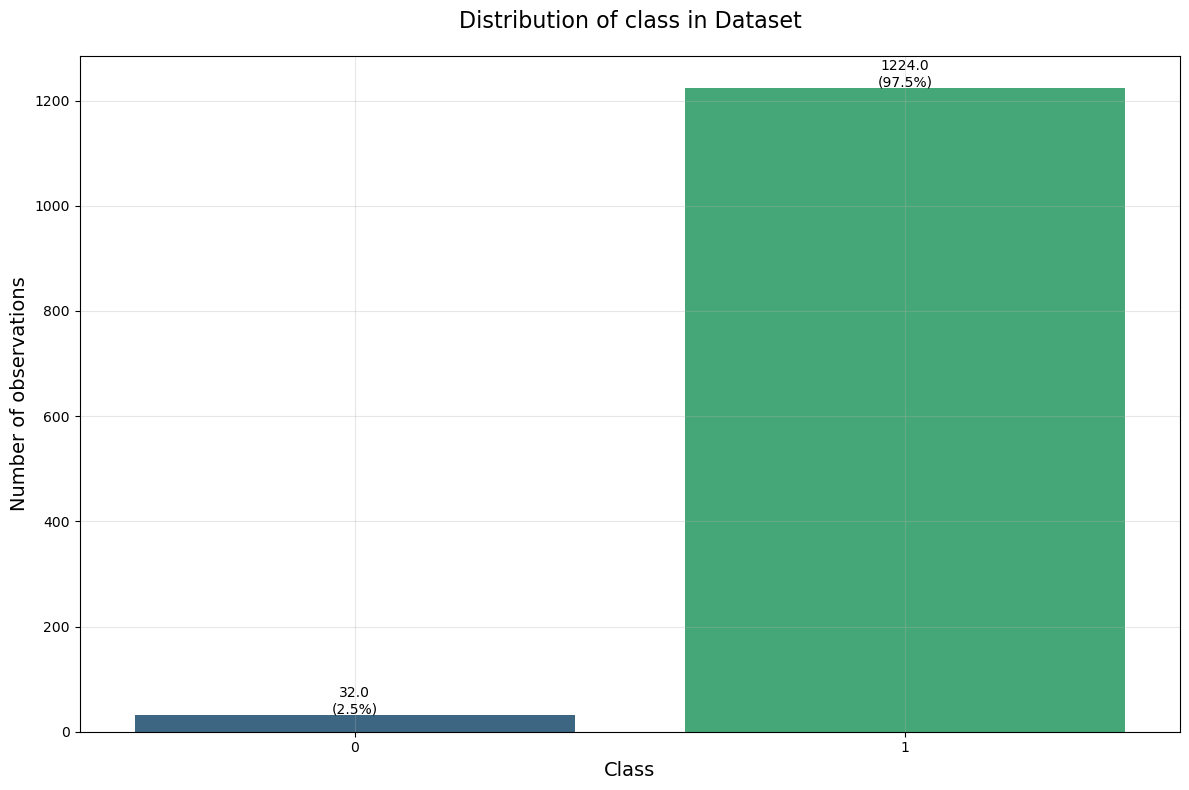

In [11]:
# Visualization of class distribution 
plt.figure(figsize=[12, 8]) 
ax = sns.countplot(x = 'PassOrFail', data=df_filtered, palette='viridis')
plt.title('Distribution of class in Dataset', fontsize=16, pad=20)
plt.xlabel('Class', fontsize=14)
plt.ylabel('Number of observations', fontsize=14)

for p in ax.patches: 
    ax.annotate(f'{p.get_height()}\n({p.get_height()/len(df_filtered):.1%})', 
               (p.get_x() + p.get_width()/2., p.get_height()),
               ha='center', va='center', fontsize=10, color='black', xytext=(0, 10), 
               textcoords='offset points')
plt.grid(True, alpha=0.3) 
plt.tight_layout()
plt.show()

In [12]:
# Removing non-numeric columns other than the target variable
non_numeric_cols = df_filtered.select_dtypes(exclude=['int64', 'float64']).columns
non_numeric_cols = [col for col in non_numeric_cols if col != 'PassOrFail']
df_filtered = df_filtered.drop(columns=non_numeric_cols)

In [13]:
# Removing columns with null values
single_unique_cols = [col for col in df_filtered.columns if df_filtered[col].nunique() == 1]
df_filtered = df_filtered.drop(columns=single_unique_cols)

In [14]:
# Missing Value Analysis 
print('\n Missing Value Analysis:')
missing_values = df_filtered.isnull().sum()
print(missing_values[missing_values > 0])


 Missing Value Analysis:
Series([], dtype: int64)


In [20]:
# Removing columns with a high proportion of missing values
missing_threshold = 0.5 
high_missing_cols = [col for col in df_filtered.columns if df_filtered[col].isnull().mean() > missing_threshold]
df_filtered = df_filtered.drop(columns=high_missing_cols)

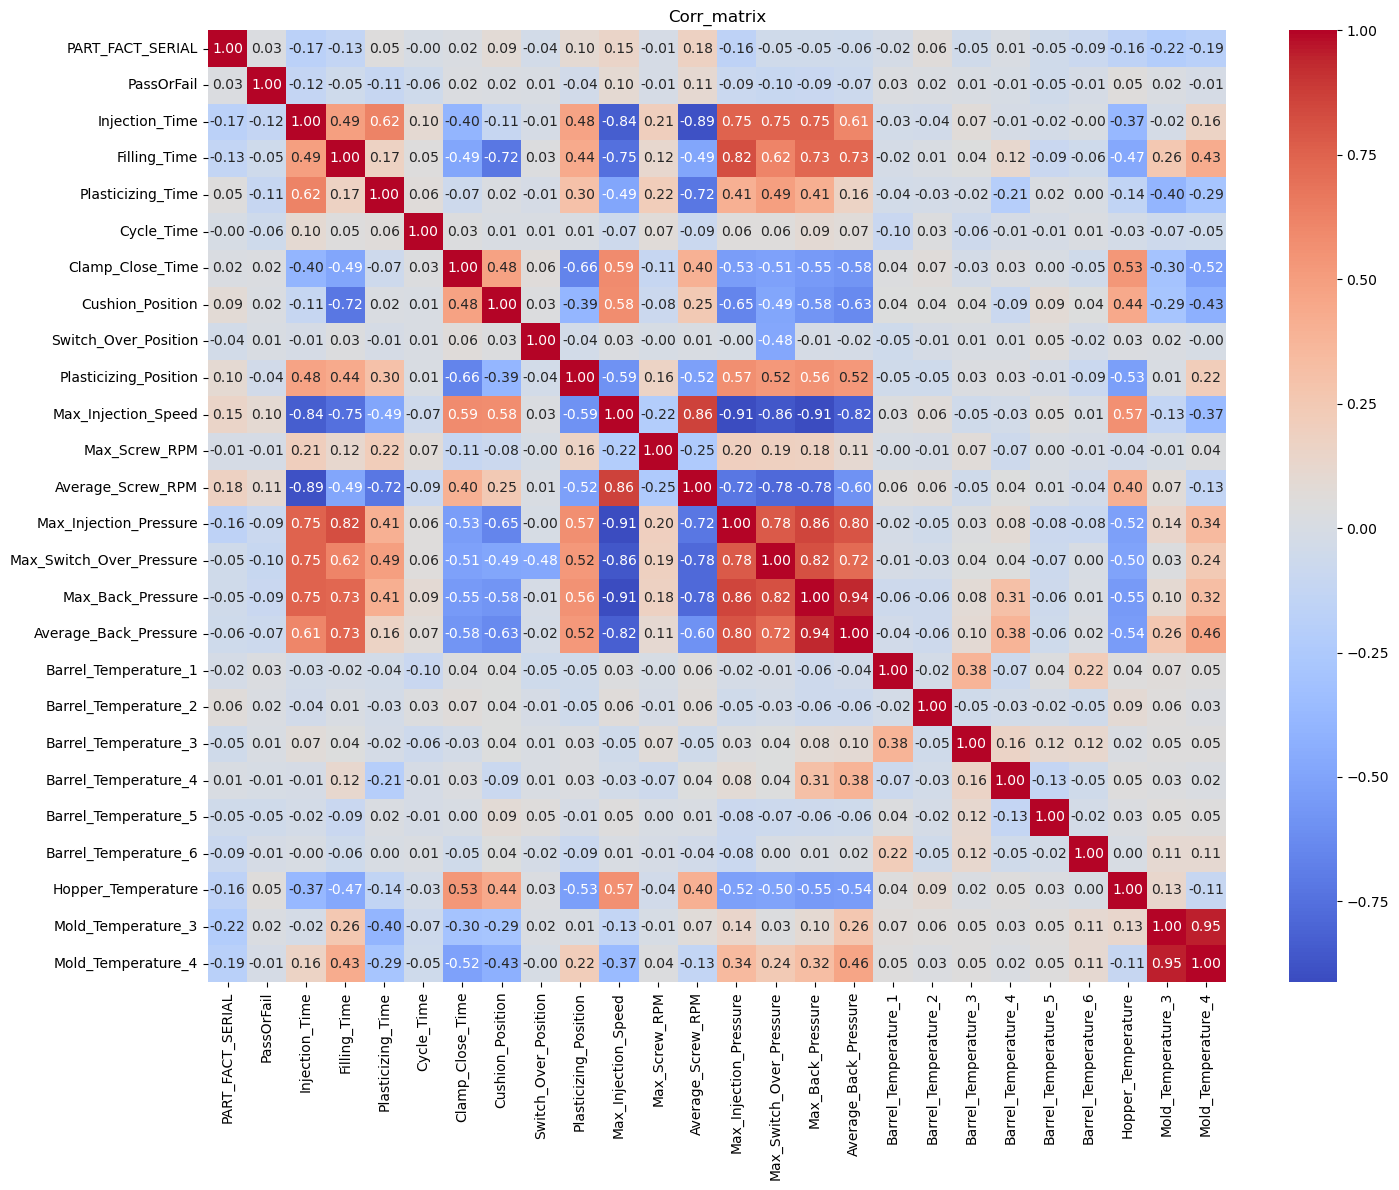

In [22]:
# Correlation Analysis
correlation_matrix = df_filtered.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Corr_matrix')
plt.tight_layout()
plt.show()

In [47]:
# Removing Correlated Features
threshold = 0.9
corr_features = set()
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > threshold:
            colname = correlation_matrix.columns[i]
            corr_features.add(colname)
            
df_filtered = df_filtered.drop(columns=corr_features)

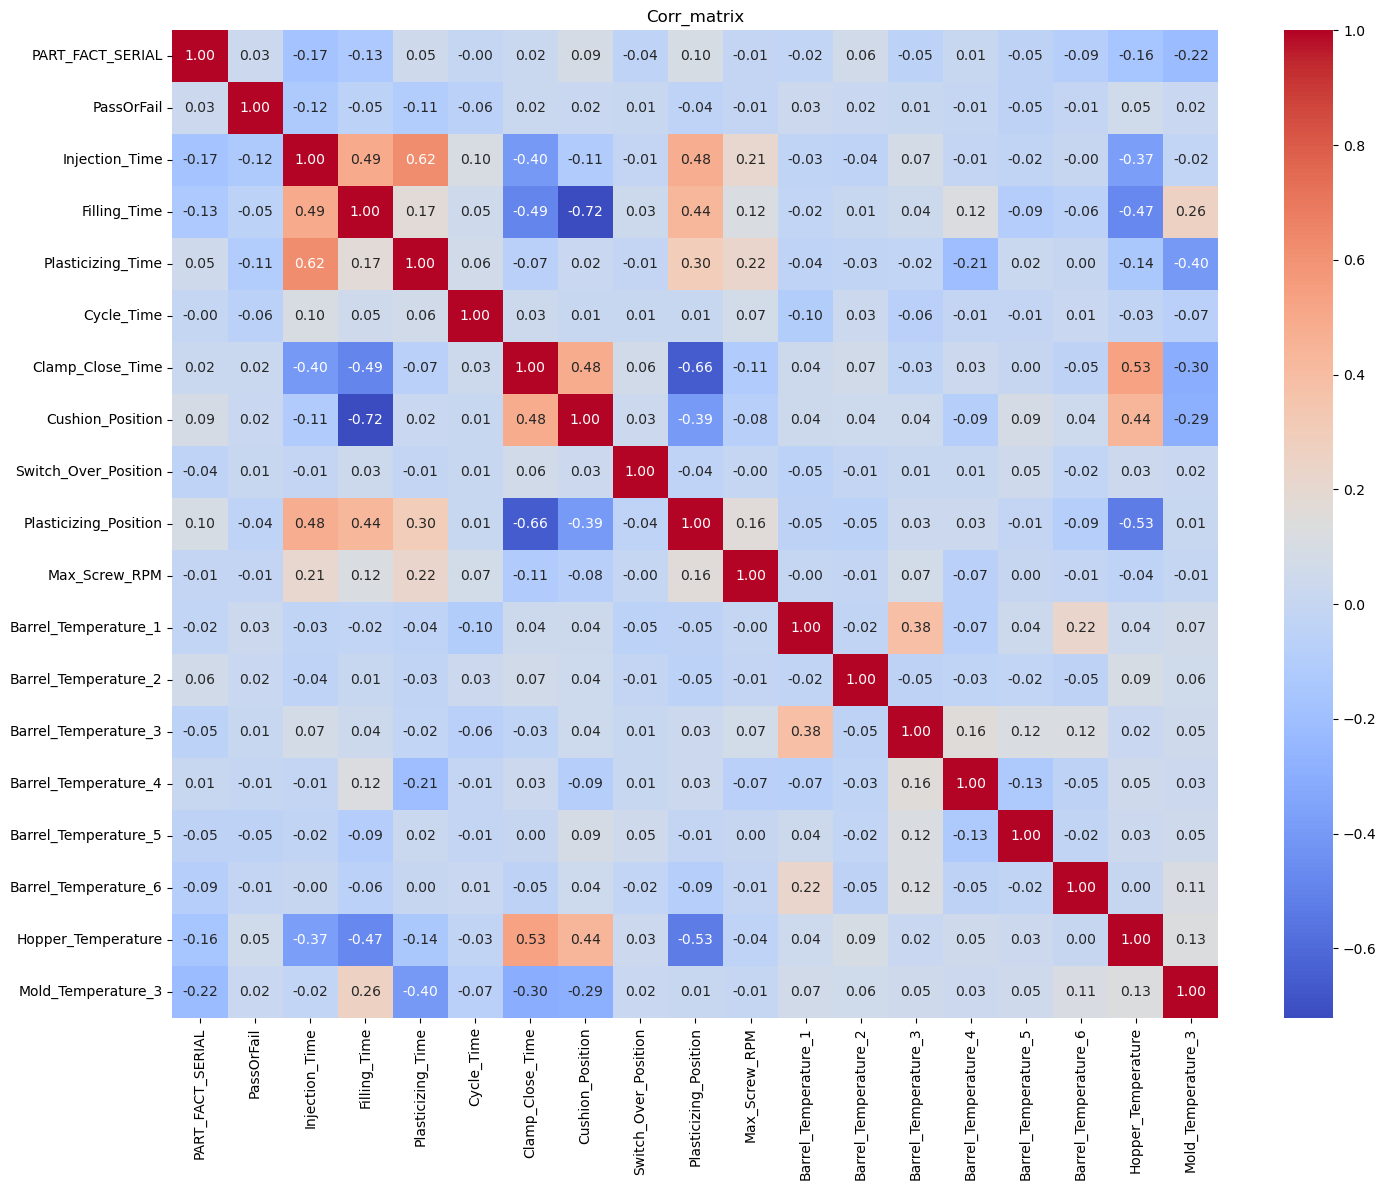

In [48]:
# Correlation Analysis
correlation_matrix = df_filtered.corr()
plt.figure(figsize=(15, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Corr_matrix')
plt.tight_layout()
plt.show()

In [23]:
df_filtered.describe()

,PART_FACT_SERIAL,PassOrFail,Injection_Time,Filling_Time,Plasticizing_Time,Cycle_Time,Clamp_Close_Time,Cushion_Position,Switch_Over_Position,Plasticizing_Position,...,Average_Screw_RPM,Max_Switch_Over_Pressure,Barrel_Temperature_1,Barrel_Temperature_2,Barrel_Temperature_3,Barrel_Temperature_4,Barrel_Temperature_5,Barrel_Temperature_6,Hopper_Temperature,Mold_Temperature_3
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,...,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,11.308917,0.957006,1.060812,0.936576,12.933790,61.771767,6.801975,654.253108,2.086975,53.584395,...,275.118951,116.416720,285.952866,285.197930,285.006051,275.360351,265.009236,234.973567,65.513535,22.566720
std,2.030104,0.203004,0.003501,0.005667,0.065119,0.040277,0.007466,0.013308,36.951780,0.014946,...,61.630892,0.774220,0.424687,0.409589,0.328880,0.678777,0.316193,0.204344,1.054991,0.683194
min,4.000000,0.000000,1.050000,0.930000,12.800000,61.709999,6.790000,654.210022,0.000000,53.549999,...,29.000000,109.699997,284.600006,284.299988,284.200012,273.799988,263.600006,234.399994,62.200001,21.200001
25%,10.000000,1.000000,1.060000,0.930000,12.890000,61.759998,6.800000,654.239990,0.000000,53.570000,...,290.500000,116.099998,285.700012,284.899994,284.799988,274.700012,264.799988,234.800003,64.900002,22.000000
50%,10.000000,1.000000,1.060000,0.940000,12.920000,61.779999,6.800000,654.250000,0.000000,53.580002,...,290.500000,116.300003,286.000000,285.200012,285.000000,275.399994,265.000000,235.000000,65.599998,22.700001
75%,12.000000,1.000000,1.060000,0.940000,12.960000,61.779999,6.810000,654.260010,0.000000,53.590000,...,290.600006,116.599998,286.200012,285.500000,285.100006,275.899994,265.200012,235.100006,66.300003,23.200001
max,18.000000,1.000000,1.080000,0.960000,13.190000,62.200001,6.810000,654.289978,655.309998,53.669998,...,290.700012,120.300003,287.100006,286.500000,285.799988,276.799988,266.399994,235.500000,67.699997,23.700001



Amount of recovered materials:
PART_FACT_SERIAL             84
PassOrFail                   32
Injection_Time               90
Filling_Time                  1
Plasticizing_Time            71
Cycle_Time                   72
Clamp_Close_Time              0
Cushion_Position              0
Switch_Over_Position          4
Plasticizing_Position        11
Max_Injection_Speed          71
Max_Screw_RPM                18
Average_Screw_RPM            74
Max_Switch_Over_Pressure     75
Barrel_Temperature_1         26
Barrel_Temperature_2          4
Barrel_Temperature_3        119
Barrel_Temperature_4          0
Barrel_Temperature_5         22
Barrel_Temperature_6          0
Hopper_Temperature            8
Mold_Temperature_3            0
dtype: int64


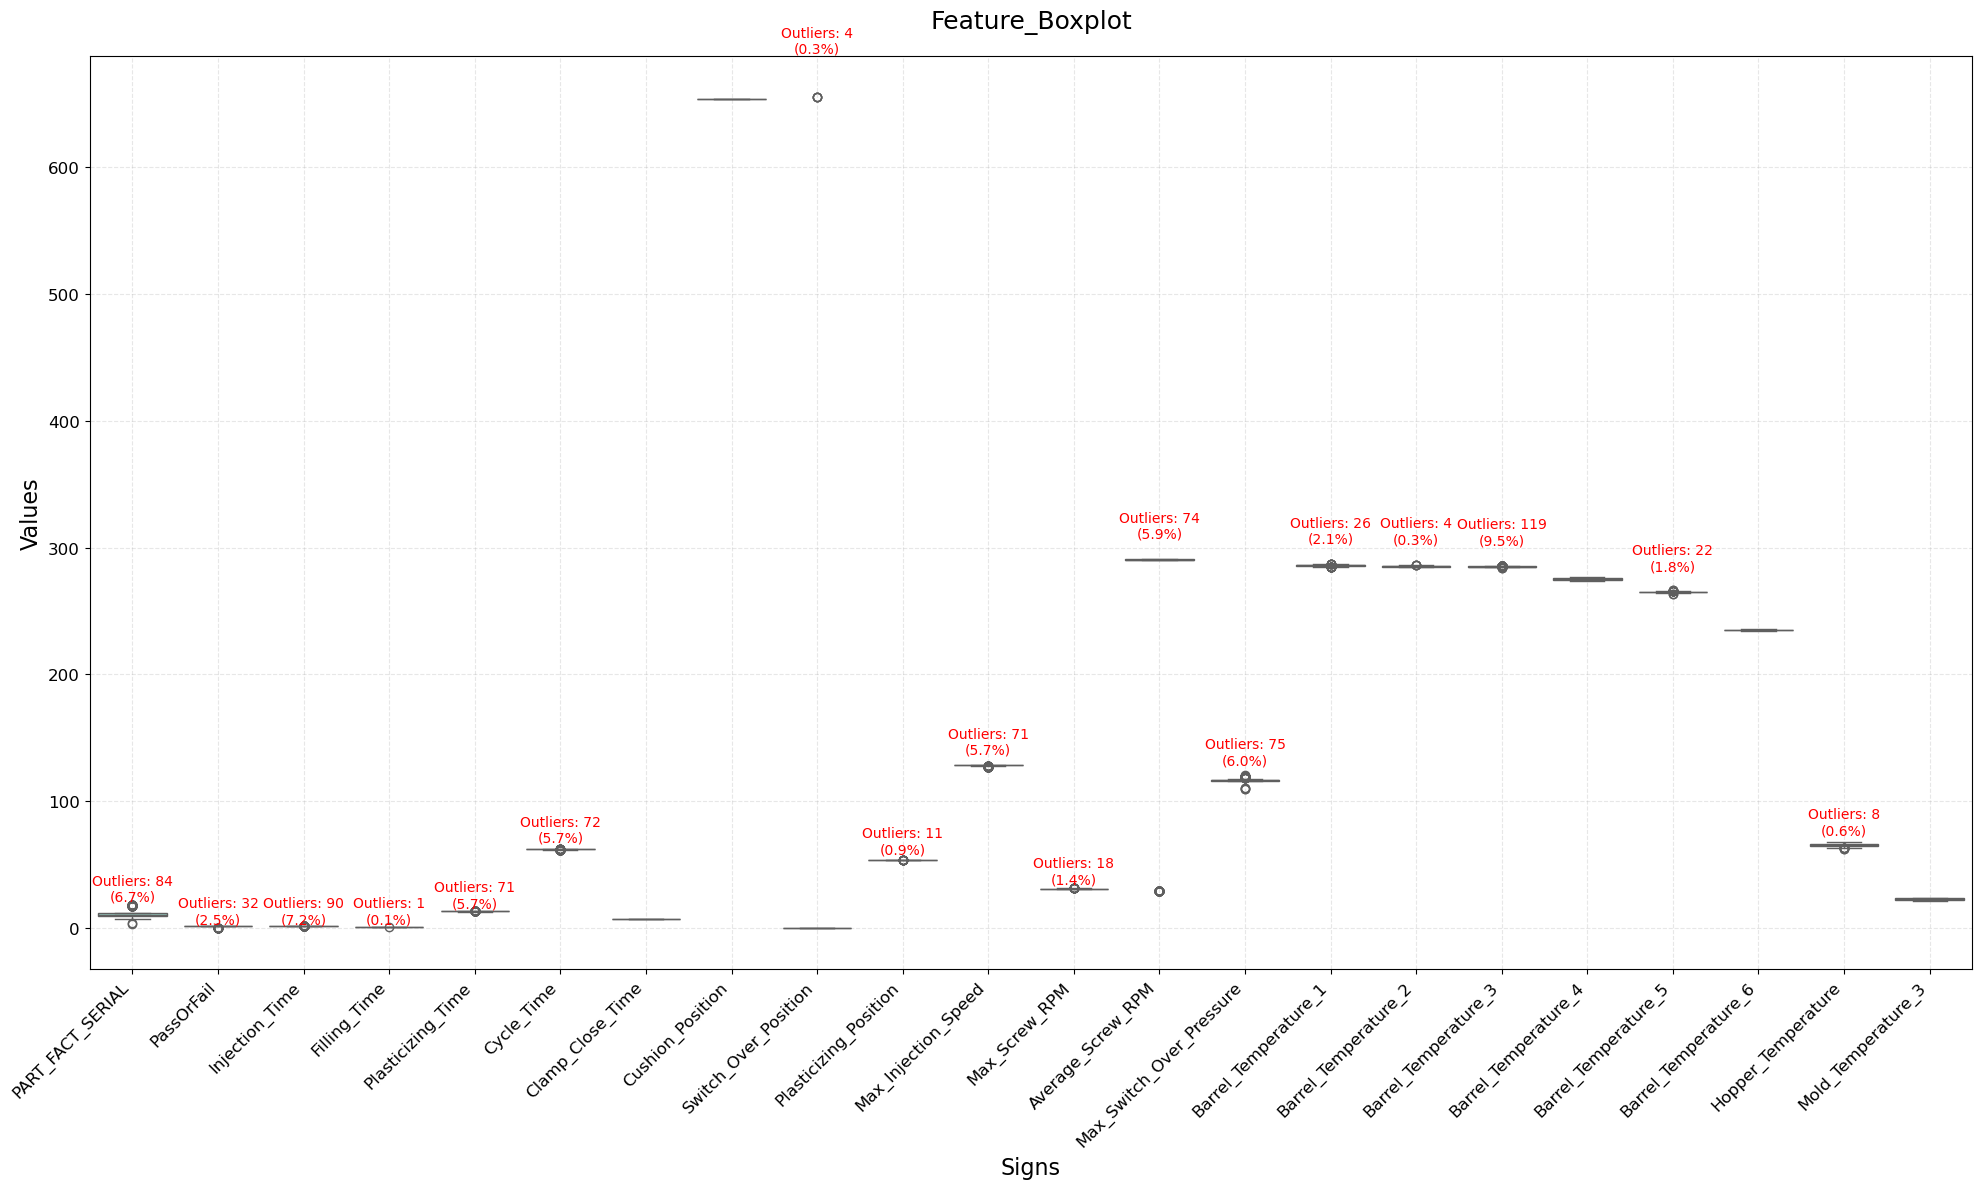

In [44]:
# Outlier analysis 
Q1 = df_filtered.quantile(0.25)
Q3 = df_filtered.quantile(0.75)
IQR = Q3 - Q1 
outliers = ((df_filtered < (Q1 - 1.5 * IQR)) | (df_filtered > (Q3 + 1.5 * IQR))).sum()
print(("\nAmount of recovered materials:"))
print(outliers)

# Visualize 
plt.figure(figsize=[20, 12])
sns.boxplot(data=df_filtered, palette='Set3', width=0.8)
plt.title("Feature_Boxplot", fontsize=18, pad=20)
plt.xlabel('Signs', fontsize=16)
plt.ylabel('Values', fontsize=16)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)

plt.grid(True, alpha=0.3, linestyle='--')

for i, col in enumerate(df_filtered.columns): 
    outliers_count = outliers[col] 
    if outliers_count > 0: 
        plt.text(i, df_filtered[col].max() * 1.05, 
                f'Outliers: {outliers_count}\n({outliers_count/len(df_filtered):.1%})',
                ha='center', va='bottom', fontsize=10, color='red')
plt.tight_layout()
plt.show()

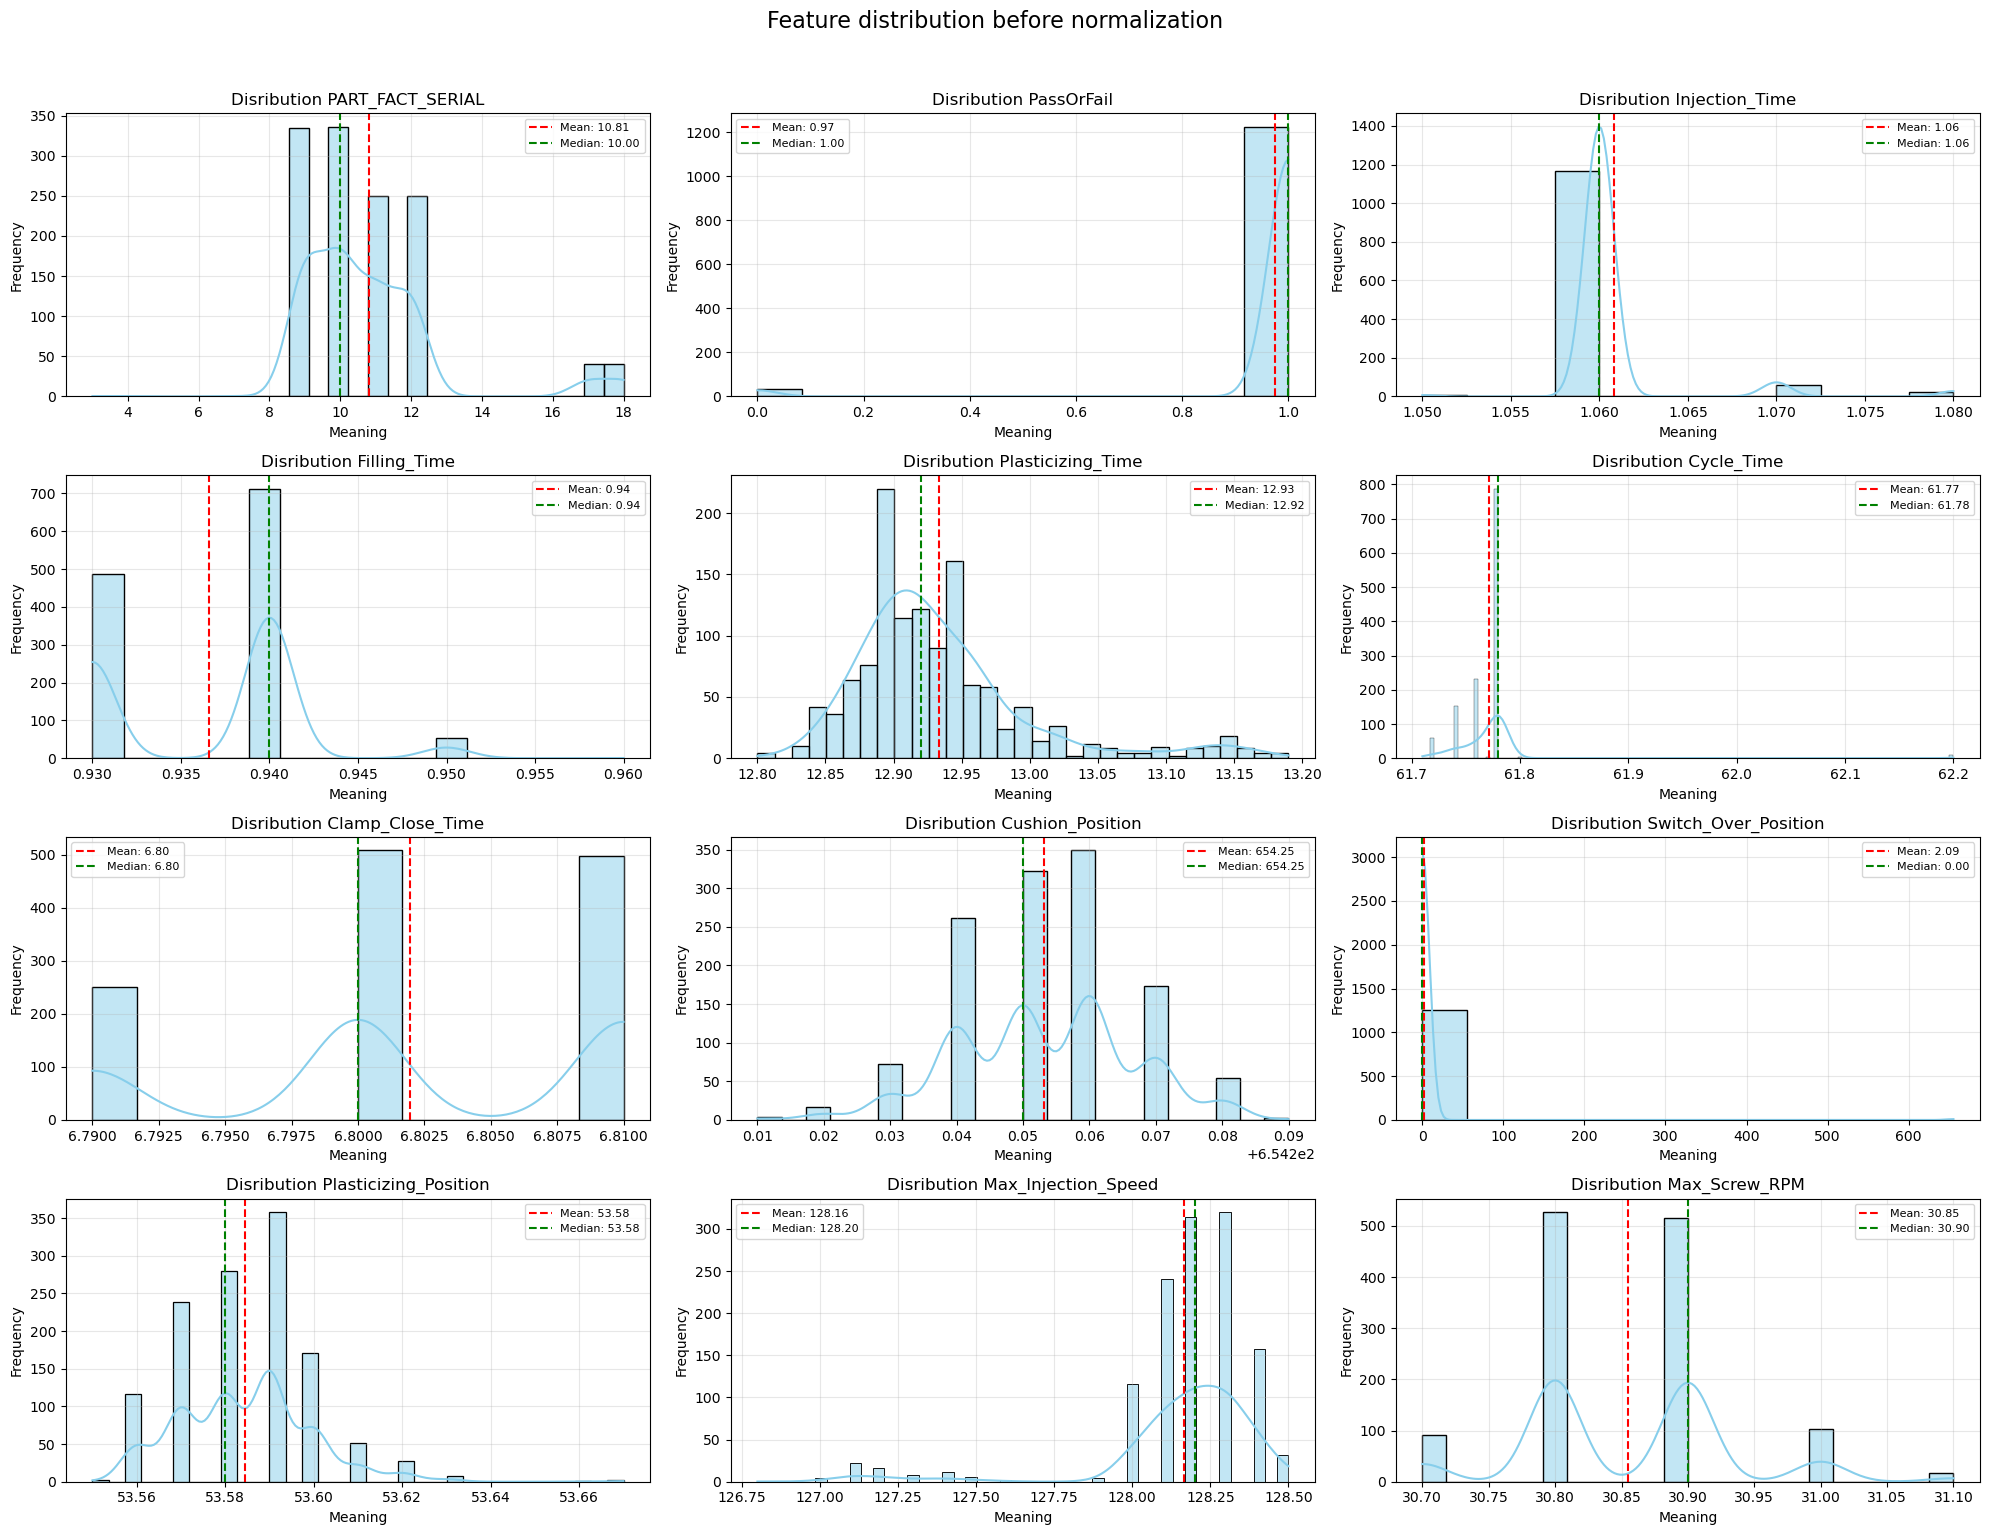

In [28]:
# Feature distribution before normalization 
plt.figure(figsize=[20, 15])
for i, col in enumerate(df_filtered.columns, 1): 
    plt.subplot(4, 3, i)
    sns.histplot(data=df_filtered[col], kde=True, color='skyblue')
    plt.title(f'Disribution {col}', fontsize=12)
    plt.xlabel('Meaning', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.grid(True, alpha=0.3)

    # Create stat 
    mean = df_filtered[col].mean()
    median = df_filtered[col].median()
    std = df_filtered[col].std()
    plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='g', linestyle='--', label=f'Median: {median:.2f}')
    plt.legend(fontsize=8)

    if i ==12: # Limiting the number of charts
        break

plt.suptitle('Feature distribution before normalization', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [29]:
X = df_filtered.drop("PassOrFail", axis=1)
y = df_filtered['PassOrFail']

In [30]:
# drop missing raws 
X = X.dropna()
y = y[X.index] # save index in y

In [51]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42
)

X_train.shape, X_test.shape

((1004, 21), (252, 21))

In [52]:
# Feature normalize
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

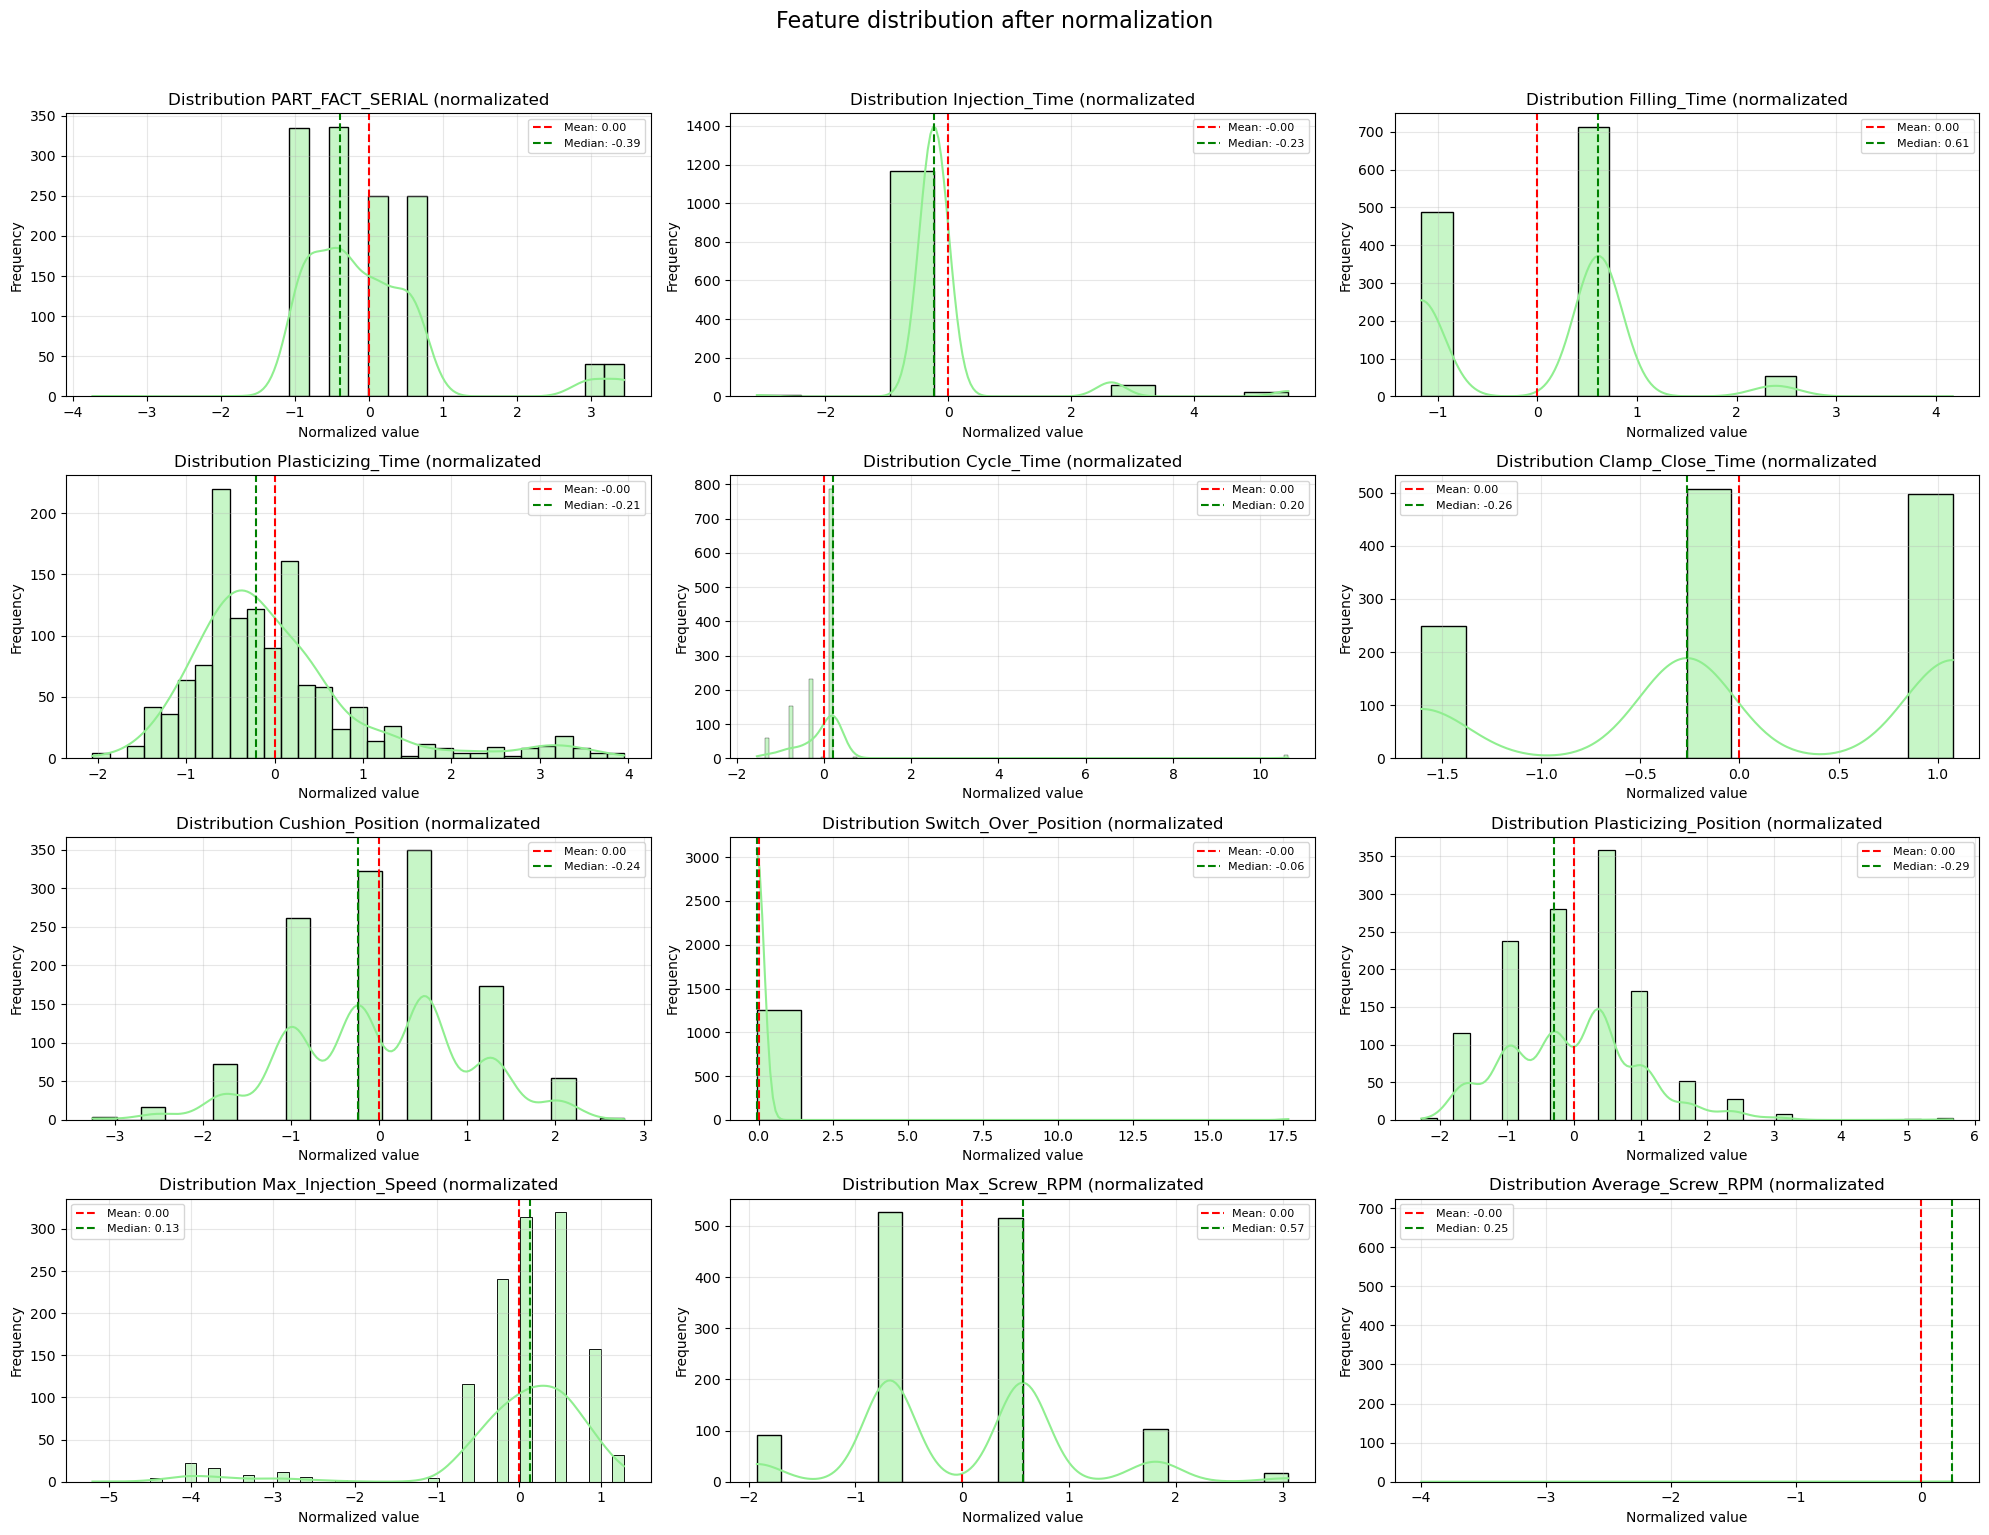

In [53]:
# Feature distribution after normalization 
plt.figure(figsize=(20, 15))
for i, col in enumerate(X_scaled.columns, 1): 
    plt.subplot(4, 3, i)
    sns.histplot(data=X_scaled[col], kde=True, color='lightgreen')
    plt.title(f"Distribution {col} (normalizated", fontsize=12)
    plt.xlabel('Normalized value', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.grid(True, alpha=0.3)

    # Stat 
    mean = X_scaled[col].mean() 
    median = X_scaled[col].median()
    std = X_scaled[col].std()
    plt.axvline(mean, color='r', linestyle='--', label=f'Mean: {mean:.2f}')
    plt.axvline(median, color='g', linestyle='--', label=f'Median: {median:.2f}')
    plt.legend(fontsize=8)
    if i == 12: 
        break

plt.suptitle('Feature distribution after normalization', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

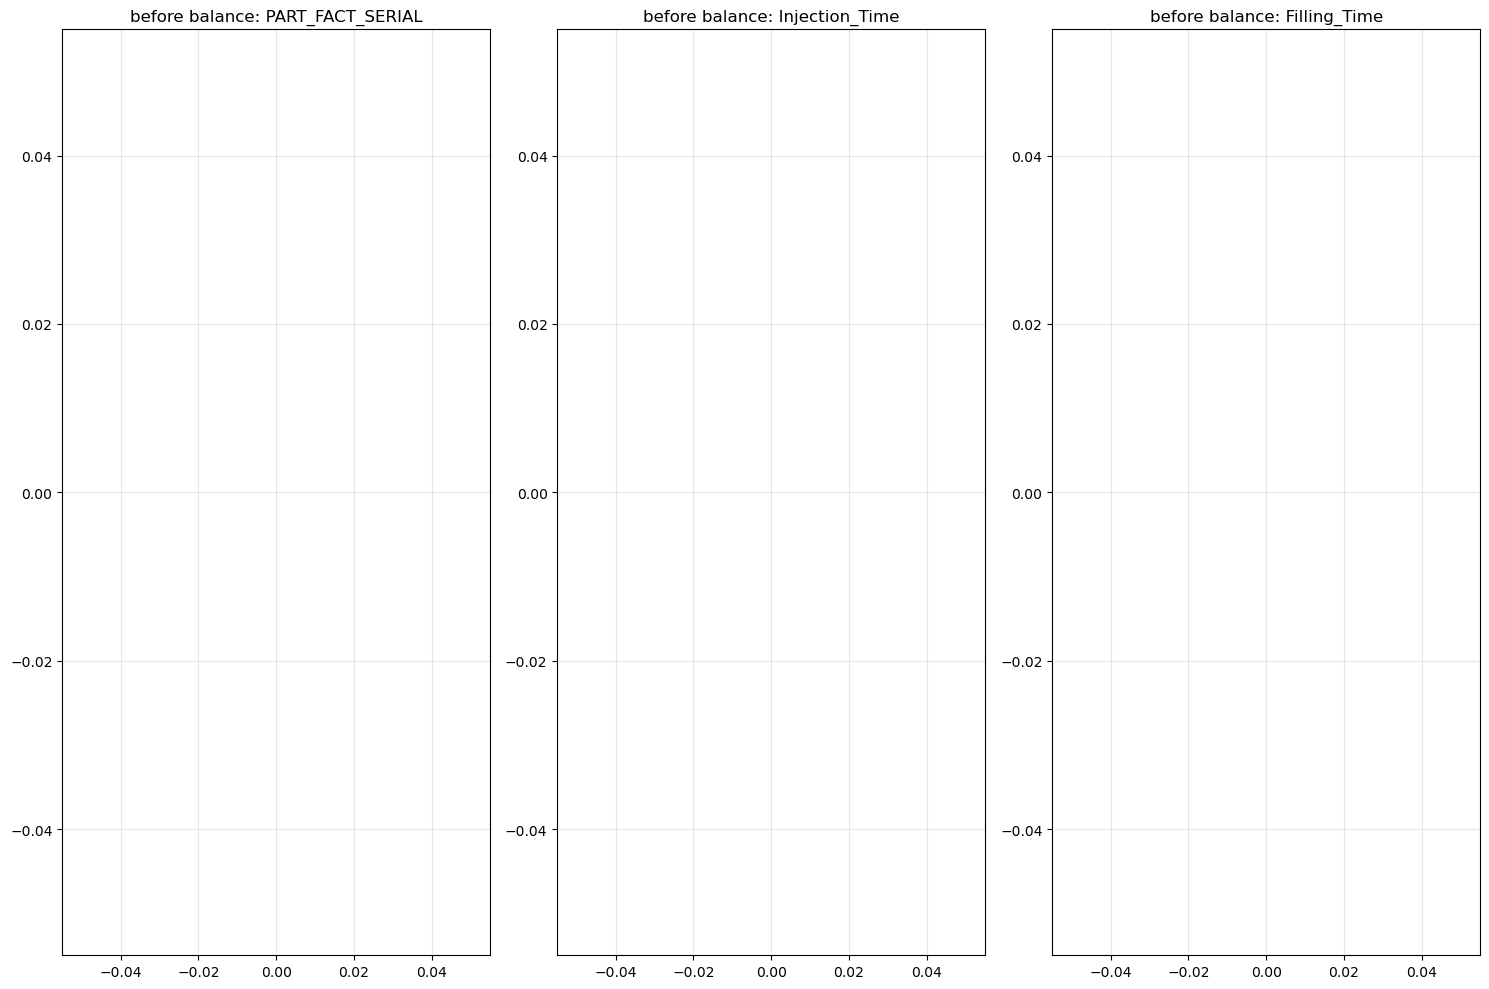

In [55]:
# Visualization of data before balancing 
top_features = X_train.columns[:3]
plt.figure(figsize=[15, 10])

for i, feature in enumerate(top_features, 1): 
    plt.subplot(1, 3, i)
    sns.scatterplot(x=feature, y='PassOrFail', data=pd.concat([X_train_scaled, y_train], axis=1), alpha=0.5)
    plt.title(f'before balance: {feature}')
    plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [73]:
# Score Baseline_model 
print("\nAbout classification for base model:")
print(classification_report(y_test, y_pred_baseline, zero_division=0))


About classification for base model:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         3
           1       0.98      1.00      0.99       123

    accuracy                           0.98       126
   macro avg       0.49      0.50      0.49       126
weighted avg       0.95      0.98      0.96       126



In [74]:
# Roc-curve baseline_model 
fpr_baseline, tpr_baseline, _ = roc_curve(y_test, y_pred_baseline) 
roc_auc_baseline = auc(fpr_baseline, tpr_baseline)

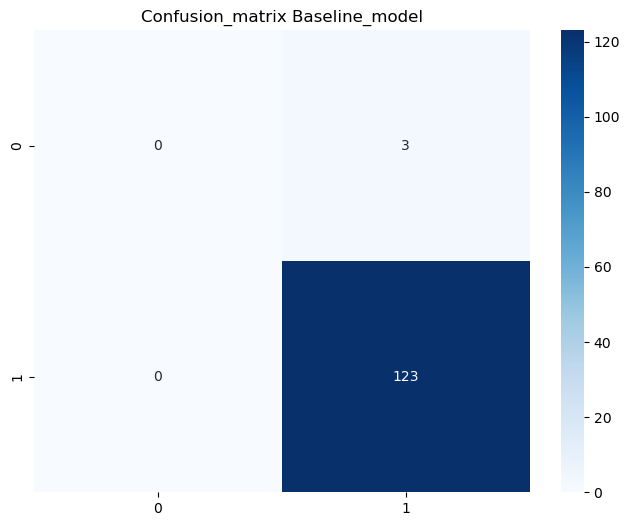

In [75]:
# confusion_matrix baseline_model  
plt.figure(figsize=[8, 6])
sns.heatmap(confusion_matrix(y_test, y_pred_baseline), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion_matrix Baseline_model')
plt.show()

In [ ]:
# Create ROC-curve figure 
plt.figure(figsize=[12, 8])
plt.plot(fpr_baseline, tpr_baseline, label=f"Baseline_model (AUC = {roc_auc_baseline:.2f})", linestyle="--")

In [ ]:
# models 
models = {
    "Logistic Regression": LogisticRegression(random_state=42, class_weight='balanced'), 
    'Random Forest': RandomForestClassifier(random_state=42, class_weight='balanced'), 
    'Gradient Boosting': GradientBoostingClassifier(random_state=42), 
    'SVM': SVC(random_state=42, class_weight='balanced', probability=True), 
    'KNN':KNeighborsClassifier()
}

In [ ]:
# Balance Methods
sampling_methods = {
    'Original': None, 
    "SMOTE": SMOTE(random_state=42), 
    "UnderSampling": RandomUnderSampler(random_state=42), 
    'SMOTEENN': SMOTEENN(random_state=42)
}

In [ ]:
# Fit and models scoring 
result = {}
for model_name, model in models.items(): 
    print(f"\n=== {model_name} ===")
    model_results = {}

    for sampling_name, sampler in sampling_methods.items(): 
        if sampler is not None:
            X_resampled, y_resampled = sampler.fit_resample(X_train_scaled, y_train)
        else: 
            X_resampled, y_resampled = X_train_scaled, y_train

        # model fit 
        model.fit(X_resampled, y_resampled)

        #Predicts 
        y_pred = model.predict(X_test_scaled)
        y_prob = model.predict_proba(X_test_scaled)[:, 1]

        #Roc-curve 
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)

        # Bild Roc-curve 
        plt.plot(fpr, tpr, 
                color='b', 
                marker='o',
                markevery=0.1,
                label=f'{model_name} - {sampling_name} (AUC = {roc_auc:.2f})')

        # Save results 
        model_results[sampling_name] = {
            'classification_report': classification_report(y_test, y_pred), 
            'confusion_matrix': confusion_matrix(y_test, y_pred), 
            'roc-auc': roc_auc
        }

        print(f'\n{sampling_name}:')
        print(classification_report(y_test, y_pred))

        # Matrix 
        plt.figure(figsize= [8, 6])
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f"Confusion_matrix = {model_name} ({sampling_name})")
        plt.show()

    result[model_name] = model_results

# ROC-curve finish 
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('All model ROC-curve')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [ ]:
# Анализ важности признаков для лучшей модели
best_model = RandomForestClassifier(random_state=42, class_weight='balanced')
best_model.fit(X_train_scaled, y_train)

In [ ]:
feature_importance = pd.DataFrame({
    'Признак': X.columns,
    'Важность': best_model.feature_importances_
}).sort_values('Важность', ascending=False)

print("\nТоп-10 самых важных признаков:")
print(feature_importance.head(10))

In [ ]:
# Визуализация важности признаков
plt.figure(figsize=(6, 4))
sns.barplot(x='Важность', y='Признак', data=feature_importance.head(10))
plt.title('Топ-10 самых важных признаков')
plt.tight_layout()
plt.show()

In [ ]:
# Кросс-валидация для лучшей модели
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='roc_auc')
print("\nРезультаты кросс-валидации:")
print(f"Средний AUC: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

In [ ]:
# Сохранение лучшей модели
import joblib
joblib.dump(best_model, 'best_model.pkl')
joblib.dump(scaler, 'scaler.pkl')